# Coursera Capstone - Predicting Venue Like Count Using Natural Language Processing of Venue "Tip" Text

Set up project token

In [1]:
# The code was removed by Watson Studio for sharing.

In [2]:
!pip install folium

     |████████████████████████████████| 92kB 2.0MB/s eta 0:00:01


In [3]:
!pip install wordcloud

     |████████████████████████████████| 368kB 2.2MB/s eta 0:00:01


Import necessary libraries

In [26]:
# Import necessary libraries
import numpy as np
import pandas as pd
import requests
import json
import nltk
import re
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
import folium
import matplotlib.pyplot as plt
%matplotlib inline
from wordcloud import WordCloud, STOPWORDS 
import seaborn as sns
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

Download nltk

In [5]:
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /home/dsxuser/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     /home/dsxuser/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /home/dsxuser/nltk_data...
[nltk_data]    |   Unzipping corpora/biocreative_ppi.zip.
[nltk_data]    | Downloading package brown to
[nltk_data]    |     /home/dsxuser/nltk_data...
[nltk_data]    |   Unzipping corpora/brown.zip.
[nltk_data]    | Downloading package brown_tei to
[nltk_data]    |     /home/dsxuser/nltk_data...
[nltk_data]    |   Unzipping corpora/brown_tei.zip.
[nltk_data]    | Downloading package cess_cat to
[nltk_data]    |     /home/dsxuser/nltk_data...
[nltk_data]    |   Unzipping corpora/cess_cat.zip.
[nltk_data]    | Downloading package cess_esp to
[nltk_data]    |     /home/ds

True

## Data Extraction

Get neighborhood and geolocation data for Manhattan

In [6]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
print('Data downloaded!')

with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)
    
neighborhoods_data = newyork_data['features']

# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
manhattan_data = neighborhoods[neighborhoods['Borough'] == 'Manhattan'].reset_index(drop=True)
manhattan_data.head()

Data downloaded!


,Borough,Neighborhood,Latitude,Longitude
0,Manhattan,Marble Hill,40.876551,-73.910660
1,Manhattan,Chinatown,40.715618,-73.994279
2,Manhattan,Washington Heights,40.851903,-73.936900
3,Manhattan,Inwood,40.867684,-73.921210
4,Manhattan,Hamilton Heights,40.823604,-73.949688


 Set up necessary Foursquare credentials (hidden)

In [98]:
# Foursquare Credentials
CLIENT_ID = '*' # your Foursquare ID
CLIENT_SECRET = '*' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: *
CLIENT_SECRET:*


Make function to fetch nearby Venue name, latitude, longitude, the text for all associated tips and like count given coordinate input. Return a pandas dataframe.

In [8]:
def getVenueMetrics(names, latitudes, longitudes, radius=500, LIMIT=12):
    
    
    # Create empty list for nearby venues
    venue_list = []
    for name, lat, lng in zip(names, latitudes, longitudes):
        # create the API request URL
        url_get_venue = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng,
            radius,
            LIMIT)


        # make the GET request and put all returned ids into the list ids
        ids = [i['id'] for i in requests.get(url_get_venue).json()["response"]['venues']]

        # make the GET request for each venue id in list ids and put it into list ratings
        ratings=[requests.get('https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(id,CLIENT_ID, CLIENT_SECRET,VERSION)).json() for id in ids]

        # loop through venue details in list ratings then extract desired info from json format, appending info to venue_list
        for r in ratings:
            try:

                venue_list.append((
                            name,
                            lat,
                            lng,
                            r['response']['venue']['name'], 
                            r['response']['venue']['location']['labeledLatLngs'][0]['lat'],
                            r['response']['venue']['location']['labeledLatLngs'][0]['lng'],
                            r['response']['venue']['categories'][0]['name'], 
                            [tip['text'] for tip in r['response']['venue']['tips']['groups'][0]['items']],
                            r['response']['venue']['likes']['count']
                ))
                
            # Except conditions return None for desired details when details missing from venue details   
            except KeyError:
                venue_list.append((
                            name,
                            lat,
                            lng,
                            None,
                            None,
                            None,
                            None,
                            [],
                            None))
            
            except TypeError:
                venue_list.append((
                            name,
                            lat,
                            lng,
                            None,
                            None,
                            None,
                            None,
                            [],
                            None))
                                 
            except IndexError:
                venue_list.append((
                            name,
                            lat,
                            lng,
                            None,
                            None,
                            None,
                            None,
                            [],
                            None))

        # Put venue_list info into dataframe
        venue_df = pd.DataFrame(venue_list)
        venue_df.columns = ['Neighborhood', 
                      'Neighborhood Latitude', 
                      'Neighborhood Longitude', 
                      'Venue', 
                      'Venue Latitude', 
                      'Venue Longitude', 
                      'Venue Category',
                      'Venue Tips',
                      'Venue Like Count']
    
    return(venue_df)

Get venue details for neighborhoods in manhattan_data dataframe (commented out as already saved output)

In [9]:
# venue_df = getVenueMetrics(names=manhattan_data['Neighborhood'],
#                 latitudes=manhattan_data['Latitude'],
#                 longitudes=manhattan_data['Longitude']
#                 )

Save dataframe as csv file to storage (commented out as already saved output)

In [10]:
# project.save_data(data=venue_df.to_csv(index=False),file_name='venue_df2.csv',overwrite=True)

Getting csv file and loading as pandas datafarme

In [11]:
venue_df2 = pd.read_csv(project.get_file('venue_df2.csv'))
print(len(venue_df2))
venue_df2 = venue_df2.dropna()
print(len(venue_df2))

480
459


## Data Preparation

Convert list of tips to list of tokens; strip strings of punctuations and stopwords and make all characters lower case.

In [12]:
stop_words = set(stopwords.words('english'))

venue_df2['Venue Tips Tokens'] = venue_df2['Venue Tips'].apply(lambda x: [w for w in nltk.word_tokenize(str(re.sub(r'[^\w\s]', '',x).lower())) if not w in stop_words])
venue_df2['Venue Tips Tokens'].head()

0                                                   []
1                      [dude, garf, gives, best, cuts]
2    [church, went, much, needed, renovation, churc...
3                [always, crowded, prices, arent, bad]
4    [traveling, uptown, 3rd, car, rear, lets, u, r...
Name: Venue Tips Tokens, dtype: object

Merge all tips into numpy array

In [13]:
words = []
for i in venue_df2['Venue Tips Tokens']:
    words=words + i
words = np.asarray(words)
len(words)

5621

Make vocabulary out of unique words in list above

In [14]:
vocab = np.unique(words)
len(vocab)

2739

Create bag-of-words model for vocabulary

In [15]:
vectorizer = CountVectorizer()
vectorizer.fit_transform(vocab)

<2739x2722 sparse matrix of type '<class 'numpy.int64'>'
	with 2722 stored elements in Compressed Sparse Row format>

Create features for venue tips based on bag-of-words model above

In [16]:
bow_features = vectorizer.transform(venue_df2['Venue Tips'])

## Exploratory Data Analysis/Visualization

Map of Manhattan Neighborhoods

In [17]:
# create map of New York using latitude and longitude values
latitude= 40.7831
longitude = -73.9712
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, borough, neighborhood in zip(manhattan_data['Latitude'], manhattan_data['Longitude'], manhattan_data['Borough'], manhattan_data['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

Map of Manhattan Venues

In [18]:
# create map of New York using latitude and longitude values
latitude= 40.7831
longitude = -73.9712
map_newyork_venue = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, venue, neighborhood in zip(venue_df2['Venue Latitude'], venue_df2['Venue Longitude'], venue_df2['Venue'], venue_df2['Neighborhood']):
    try:
        label = '{}, {}'.format(neighborhood, venue)
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color='blue',
            fill=True,
            fill_color='#3186cc',
            fill_opacity=0.7,
            parse_html=False).add_to(map_newyork_venue)  
    except ValueError:
        pass

    
map_newyork_venue

In [19]:
## Simple WordCloud
text = 'all your base are belong to us all of your base base base'

def generate_wordcloud(text): # optionally add: stopwords=STOPWORDS and change the arg below
    wordcloud = WordCloud(font_path='/Library/Fonts/Verdana.ttf',
                          relative_scaling = 1.0,
                          stopwords = {'to', 'of'} # set or space-separated string
                          ).generate(text)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

Wordcloud for terms found in venue tips

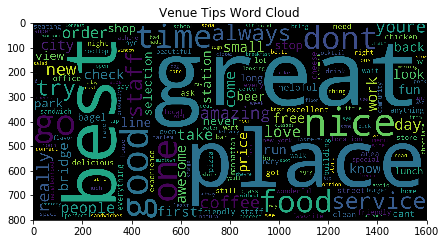

In [20]:
wc = WordCloud(width=1600, height=800).generate(" ".join(words))
plt.imshow(wc)
plt.figure(1, figsize=(300,150))
plt.title("Venue Tips Word Cloud")
plt.tight_layout(pad=0)
plt.show()

Distribution of like counts

Text(0.5, 1.0, 'Distribution of Venue Like Counts')

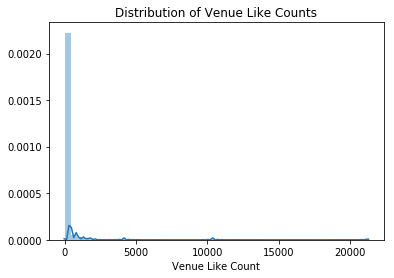

In [21]:
sns.distplot(venue_df2['Venue Like Count']).set_title("Distribution of Venue Like Counts")


As you can see in the plot above, the venue like counts follow what appears to be a log-normal distribution where most venues have 0 likes. This poses a problem, as a model attempting to predict this data will most likely default to predicting a like count of 0 for all venues and receiving decent accuracy while being a useless model. It is therefore more practical to predict the log(venue like count). This also is problematic as the log(0) trends to -inf. Therefore, I will pad all values by an arbitrary -.01 in an attempt to avoid invalid values while still allowing values to be predictable.

Text(0.5, 1.0, 'Log Distriubtion of Venue like Counts')

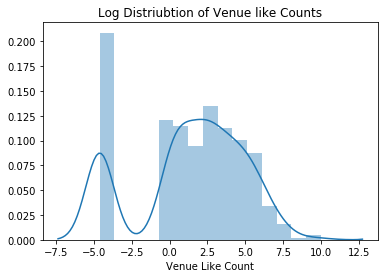

In [22]:
log_likes = venue_df2['Venue Like Count'].apply(lambda x: np.log(x+.01))
sns.distplot(log_likes).set_title("Log Distriubtion of Venue like Counts")

The graph produced is bimodal: with one mode for like counts of 0 and the other a relatively normal distribution centering around log(2.5)

Top 5 venue categories by like count

In [23]:
venue_df2.groupby('Venue Category').agg(['count','mean'])['Venue Like Count'].sort_values(by='mean',ascending=False).head(5)

,count,mean
Venue Category,,
Park,13,2537.692308
Monument / Landmark,2,2079.500000
Convention Center,1,1815.000000
Movie Theater,1,1260.000000
Beer Garden,1,909.000000


Mean Like count for all venues in data

In [24]:
venue_like_count_mean = np.mean(venue_df2['Venue Like Count'])

## Model Development/Evaluation

Split bag-of-word venue tip features and log(venue like counts) into train/test split

In [92]:
X_train, X_test, y_train, y_test = train_test_split(bow_features, log_likes, test_size=0.2, random_state=17)

### Baseline Model - Mean Venue Like Count

Our baseline model will simply be the mean like count across all venues

In [93]:
baseline = [np.mean(y_test)] * len(y_test)

Evaluation of baseline model. All evaluations will use mean squared error (MSE).

In [94]:
mean_squared_error(baseline, y_test)

12.52653764613815

### Experimental Model - Linear Regression

Implement linear regression model

In [95]:
regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

Make predictions and find mean squared error

In [96]:
regr_pred = regr.predict(X_test)
mean_squared_error(regr_pred, y_test)

10.993733156962813

Plot regression results

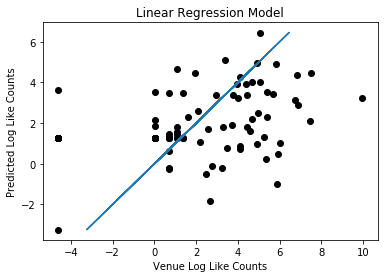

In [97]:
plt.scatter(y_test, regr_pred, color='black')
plt.plot(regr_pred, regr_pred)
plt.title("Linear Regression Model")
plt.xlabel("Venue Log Like Counts")
plt.ylabel("Predicted Log Like Counts")
plt.show()

Therefore, using a bag-of-words model with venue tips, we can more accurately predict venue like counts than simply taking the average venue like count for this give dataset: 12 nearest venues to the 40 manhattan neighborhoods. 

## 